In [3]:
from sklearn import model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline 
%config InlineBackend.figure_format="retina" 

In [4]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下字体

In [5]:
# 画决策树

import matplotlib.pyplot as plt
from pylab import *
 
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
 
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotNode(nodeTxt, centerPt, parentPt, nodeType): # 绘制带箭头的注解
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords="axes fraction", xytext=centerPt, textcoords="axes fraction", va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def getNumLeafs(myTree): # 获取叶节点的数目
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ == 'dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict':
                numLeafs += getNumLeafs(secondDict[key])
            else: numLeafs += 1
    else:
        numLeafs += 1
    return numLeafs
 
def getTreeDepth(myTree): # 获取树的层数
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ == 'dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict':
                thisDepth = 1 + getTreeDepth(secondDict[key])
            else: 
                thisDepth = 1
            if thisDepth > maxDepth: 
                maxDepth = thisDepth
    else:
        maxDepth = 1
    return maxDepth
 
def retrieveTree(i): # 获取预定义的树
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]
 
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
    plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    if type(secondDict).__name__=='dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__=='dict':
                plotTree(secondDict[key],cntrPt,str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
                plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                cntrPt, leafNode)
                plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    else:
        plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
        plotNode(secondDict, (plotTree.xOff, plotTree.yOff),cntrPt, leafNode)
        plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(secondDict))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

    
def createPlot(inTree):
    fig = plt.figure(1, figsize=(12, 8), facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

In [6]:
# 判断当前数据集中是否类别全部相同
def same_category(D):
    num = D.loc[:,'好瓜'].nunique()
    if num == 1:
        flag = True
    else:
        flag = False
    return flag, D.iloc[0,-1]
    
# 判断当前属性集是否为空
def empty_attribute(A):
    num=A.nunique()
    if num==0:
        return True
    else:
        return False

# 判断当前数据集在属性集A上取值是否相同
def sameOnA(D,A):
    num = D.loc[:,A].nunique()
    num=np.sum(num)
    numA = len(A)
    if num == numA:
        return True
    else:
        return False

# 找出数据集D中样本数最多的类别
def findMost(D):
    good=D.loc[D['好瓜']==1,:].shape[0]
    bad=D.loc[D['好瓜']==0,:].shape[0]
    if good>=bad:
        return '好瓜'
    else:
        return '坏瓜'

# 使用信息熵
def crossEnt(D):
    num=D.shape[0]
    curEnt=0
    cate=[1,0]
    for c in cate:
        c_num=D.loc[D['好瓜']==c,:].shape[0]
        if c_num==0:
            tmp=0
        else:
            pk=c_num/num
            tmp=-pk*np.log2(pk)    
        curEnt+=tmp
    return curEnt

#在D中找出取值为a的子集
def getDv_a(D,A,a):
    Dv_a=D.loc[D[A]==a,:]
    return Dv_a

# 基于交叉熵找出当前最优属性
def findBestA(D,A):
    Ent=crossEnt(D)
    selectA=''
    Emax=0
    for a in A:
        ent=0
        D_num=D.shape[0]
        for av in pd.unique(D.loc[:, a]):
            Dv_a=getDv_a(D,a,av)
            a_num=Dv_a.shape[0]
            ent+=a_num *crossEnt(Dv_a)/D_num
        
        if Ent-ent>Emax:
            Emax=Ent-ent
            selectA=a
            
    return selectA

In [7]:
# 通过信息增益求划分点
def getGain(D,A,p):
    
    Ent=crossEnt(D)
    num=D.shape[0]

    nowD=D.copy()# 注意仅生成副本

    for i in range(num):
        if nowD.loc[i,A]>p:
            nowD.loc[i,A]='大'
        else:
            nowD.loc[i,A]='小'
    ent=0
    
    for av in pd.unique(nowD.loc[:, A]):
            Dv_a=getDv_a(nowD,A,av)
            a_num=Dv_a.shape[0]
            ent+=a_num *crossEnt(Dv_a)/num
    
    return Ent-ent
    
def getPoint(D,A):

    datalist=D.loc[:,A]

    sortdata = sorted(datalist)
    Pmax=0
    Gmax=0
    for i in range(len(sortdata)-1):
        tmp=(sortdata[i+1]+sortdata[i])/2
        nowGain=getGain(D,A,tmp)
        if nowGain>Gmax:
            Pmax=tmp
            Gmax=nowGain
    return Pmax
            
    
def ReadData(pathname):
    data=pd.read_csv(pathname)
    data.loc[data['好瓜']=='是', '好瓜'] = 1
    data.loc[data['好瓜']=='否', '好瓜'] = 0
    data = data.iloc[:,1:]
    
    Prho=getPoint(data,'密度')
    Psug=getPoint(data,'含糖率')

    for i in range(data.shape[0]):
        if data.loc[i,'密度']>Prho:
            data.loc[i,'密度']='大于划分点'
        else:
            data.loc[i,'密度']='不大于划分点'
        
        
        if data.loc[i,'含糖率']>Psug:
            data.loc[i,'含糖率']='大于划分点'
        else:
            data.loc[i,'含糖率']='不大于划分点'
            
    return data

In [12]:
def treeGenerate(D,A,root,lastNode,lastA):
    flag, category = same_category(D)
    if flag:
        if category==1:
            lastNode[lastA] = '好瓜'  
        else:
            lastNode[lastA] = '坏瓜'
        return
    
    if empty_attribute(A) or sameOnA(D,A):
        lastNode[lastA]=findMost(D)
        return
    
    best_a=findBestA(D,A)

    root[best_a]={}
    for av in pd.unique(data.loc[:,best_a]):
        Dv = getDv_a(D,best_a,av)
        if Dv.shape[0]==0:
            root[best_a][av]=findMost(D)
        else:
            A_ = A.drop(best_a)
            root[best_a][av] = {}
            lastA = av

            treeGenerate(Dv,A_,root[best_a][av],root[best_a],lastA)
            print(best_a,av,root[best_a][av])
    

密度 大于划分点 好瓜
密度 不大于划分点 坏瓜
纹理 清晰 {'密度': {'大于划分点': '好瓜', '不大于划分点': '坏瓜'}}
触感 硬滑 坏瓜
触感 软粘 好瓜
纹理 稍糊 {'触感': {'硬滑': '坏瓜', '软粘': '好瓜'}}
纹理 模糊 坏瓜
{'纹理': {'清晰': {'密度': {'大于划分点': '好瓜', '不大于划分点': '坏瓜'}}, '稍糊': {'触感': {'硬滑': '坏瓜', '软粘': '好瓜'}}, '模糊': '坏瓜'}}


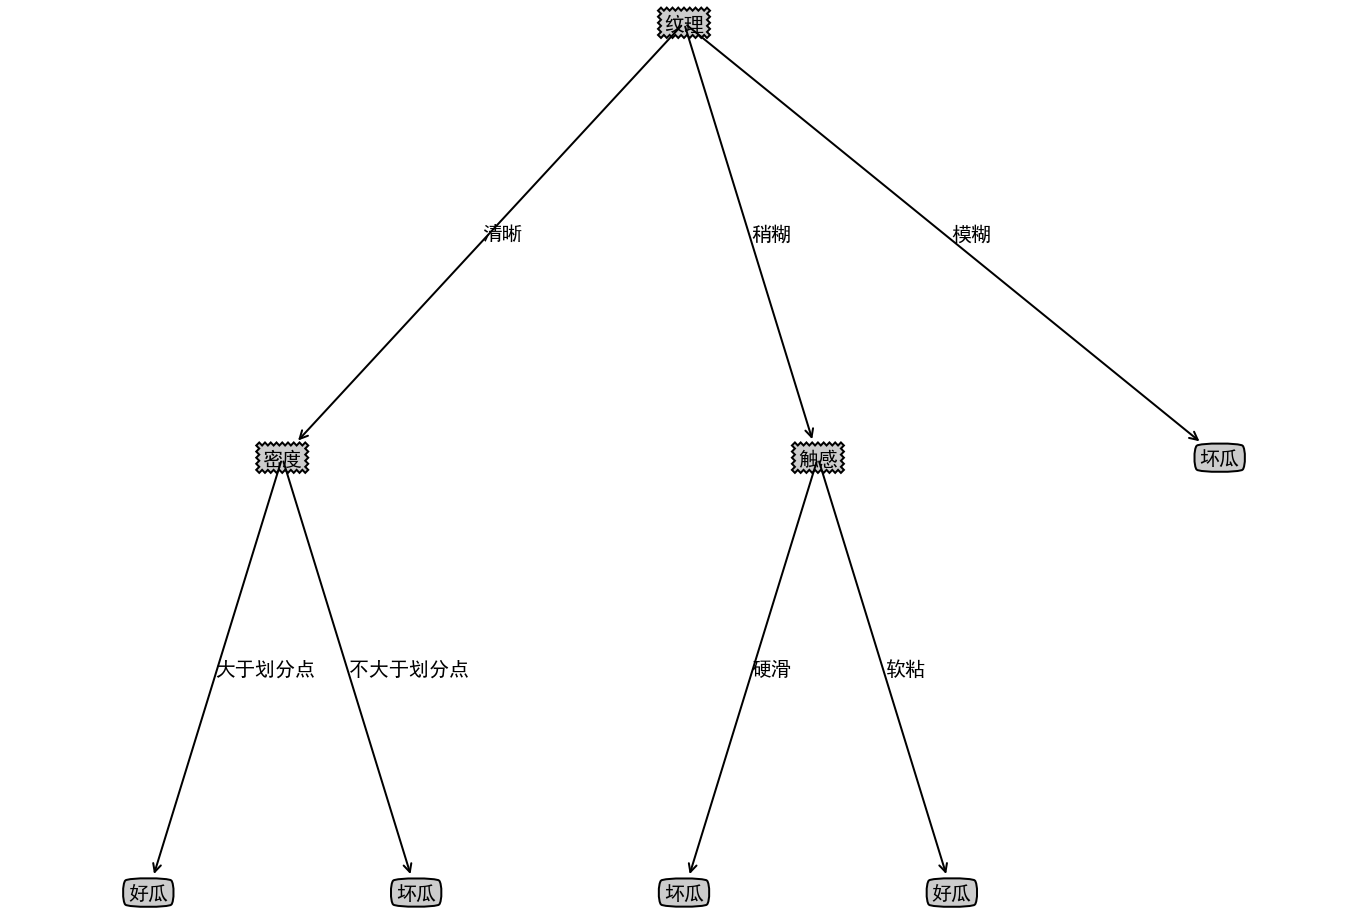

In [13]:
if __name__ == '__main__':
    data=ReadData('./watermelon_3.csv')
    root={}
    attribute=data.columns[:-1]

    lastNode=None
    lastA=None
    treeGenerate(data,attribute,root,lastNode,lastA)
    print(root)
    createPlot(root)
